In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

In [35]:
import pandas as pd
import numpy as np

TS = 48 # Time steps
FEATURE = 'GC'

df = pd.read_csv('AusGrid_preprocess.csv', header=[0,1], index_col=0)
df = df.set_index(pd.to_datetime(df.index))
df.columns = df.columns.set_levels(df.columns.levels[0].astype('int64'), level=0)
df.head()

Customer             1                    3                 4           \
categories            GG      GC      CL   GG      GC   CL   GG     GC   
2012-07-01 00:30:00  0.0  1710.0  2500.0  0.0  1930.0  0.0  0.0  168.0   
2012-07-01 01:00:00  0.0  1572.0  2500.0  0.0  1854.0  0.0  0.0  168.0   
2012-07-01 01:30:00  0.0  1208.0  2500.0  0.0  2718.0  0.0  0.0  164.0   
2012-07-01 02:00:00  0.0  1088.0  2526.0  0.0   120.0  0.0  0.0  168.0   
2012-07-01 02:30:00  0.0  1194.0   262.0  0.0   118.0  0.0  0.0  172.0   

Customer                     5    ...  297                 298         299  \
categories               CL   GG  ...   GG     GC      CL   GG     GC   GG   
2012-07-01 00:30:00     0.0  0.0  ...  0.0  282.0     0.0  0.0  314.0  0.0   
2012-07-01 01:00:00     0.0  0.0  ...  0.0  514.0     0.0  0.0  254.0  0.0   
2012-07-01 01:30:00  3860.0  0.0  ...  0.0  394.0     0.0  0.0  244.0  0.0   
2012-07-01 02:00:00  3956.0  0.0  ...  0.0  546.0  2660.0  0.0  240.0  0.0   
2012-07-01 02:30:00  1568.0  0.0  ...  0.0  412.0     0.0  0.0  212.0  0.0   

Customer                     300                 
categories               GC   GG     GC      CL  
2012-07-01 00:30:00  1082.0  0.0  438.0  5346.0  
2012-07-01 01:00:00   200.0  0.0  198.0  2492.0  
2012-07-01 01:30:00   180.0  0.0  268.0     0.0  
2012-07-01 02:00:00   188.0  0.0  200.0     0.0  
2012-07-01 02:30:00    92.0  0.0  246.0     0.0  

[5 rows x 725 columns]

In [36]:
customers = sorted(df.columns.levels[0])
max_values = []
for c in customers:
    max_values.append(df[c][FEATURE].max())

normalize = max(max_values)
print(normalize)



13134.0


In [37]:
def gen_data(X, y, num_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - num_steps):        
        Xs.append(np.reshape(X[i:(i + num_steps)], (num_steps, 1)))
        ys.append(y[i + num_steps])
    return np.array(Xs), np.reshape(np.array(ys), (len(ys)))
    
customers = sorted(df.columns.levels[0])
x_list = []
y_list = []
for c in customers[:18]:
    tmp = df[c][FEATURE].to_numpy()/normalize
    tmp_x, tmp_y = gen_data(tmp, tmp, TS)        
    x_list.append(tmp_x)
    y_list.append(tmp_y)
x_data = np.array(x_list)
y_data = np.array(y_list)
print(x_data.shape, y_data.shape)


(18, 17472, 48, 1) (18, 17472)


In [38]:
NT = 15
x_train, y_train = x_data[:NT], y_data[:NT]
print(x_train.shape, y_train.shape)
x_test, y_test = x_data[NT:], y_data[NT:]
print(x_test.shape, y_test.shape)

(15, 17472, 48, 1) (15, 17472)
(3, 17472, 48, 1) (3, 17472)


In [39]:
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
x_train.shape

(15, 17472, 48, 1)

In [40]:
# Split data for federated learing
num_clients = 5
client_data_size = len(x_train) // num_clients
client_data = [(x_train[i * client_data_size: (i + 1) * client_data_size],
                y_train[i * client_data_size: (i + 1) * client_data_size])
               for i in range(num_clients)]
# len(client_data)
client_data[0][1].shape

(3, 17472)

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

def create_model():
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(x_train.shape[2], x_train.shape[3]), return_sequences=False),
        Dense(4),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [42]:
# Create model
model = create_model()
model.summary()

/Users/jwheo/Projects/etc_project/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_92 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initialize client models
def initialize_client_models(num_clients, global_weights=None):
    client_models = []
    for _ in range(num_clients):
        model = create_model()
        if global_weights is not None:
            model.set_weights(global_weights)  # 모든 클라이언트 모델에 동일한 글로벌 가중치 설정
        client_models.append(model)
    return client_models

# Average weight for federated model
def federated_averaging(client_models, client_data):
    global_model = create_model()
    
    # Calculate weights for each client modle based on number of samples
    num_samples = [data[0].shape[0] for data in client_data]
    total_samples = sum(num_samples)
    client_weights = [samples / total_samples for samples in num_samples]
    
    # Averge weights of each client model for global model
    model_weights = [model.get_weights() for model in client_models]
    print('num_samples : ', num_samples)
    average_weights = []
    for weights_list in zip(*model_weights):
        average_weights.append(np.average(weights_list, axis=0, weights=client_weights))
    
    global_model.set_weights(average_weights)
    return global_model

# Train client models
def train_client_model(client_data, model, epochs=1, batch_size=64):
    print(client_data[0].shape)
    # history = model.fit(client_data[0], client_data[1], epochs=epochs, batch_size=batch_size, verbose=1)
    for x, y in zip(client_data[0], client_data[1]):
        history = model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return history

def evaluate_global(model, x_test, y_test):
    total_test_loss = 0.0
    total_test_acc = 0.0
    for x_ev, y_ev in zip(x_test, y_test):
        test_loss, test_acc = model.evaluate(x_ev, y_ev, verbose=0)
        total_test_loss += test_loss
        total_test_acc += test_acc
        print('test loss : ', test_loss)

    print('Total loss : ', total_test_loss, 'Length : ', len(x_test))
    return total_test_loss/(len(x_test)), total_test_acc/(len(y_test))
        
# Learing global model 
def federated_learning(num_rounds, num_clients, client_data):
    # Create global model
    global_model = create_model()
    global_model_loss = []
    
    for round in range(num_rounds):
        print(f"Round {round + 1}/{num_rounds}")
        
        # 클라이언트 모델 초기화
        client_models = initialize_client_models(num_clients, global_weights=global_model.get_weights())
        
        # Training client models
        for i in range(num_clients):
            print(f"Training client model {i + 1}...")
            train_client_model(client_data[i], client_models[i])
        
        # Create Global model as FedAvg
        global_model = federated_averaging(client_models, client_data)
        
        # Evaluate Global model
        # test_loss, test_acc = global_model.evaluate(x_test[0], y_test[0], verbose=0)
        test_loss, test_acc = evaluate_global(global_model, x_test, y_test)
        global_model_loss.append(test_loss)
        print(f'Global model test loss: {test_loss:f}')
        
        # Show learning status
        # client_accuracies = [model.evaluate(x_test, y_test, verbose=0)[1] for model in client_models]
        client_loss = [evaluate_global(model, x_test, y_test)[0] for model in client_models]

        plt.figure(figsize=(10, 6))
        plt.plot(range(num_clients), client_loss, 'bo-', label='Client Models')
        plt.axhline(y=test_loss, color='r', linestyle='-', label='Global Model')
        plt.xlabel('Client')
        plt.ylabel('Loss')
        plt.title(f'Client Models vs Global Model Loss (Round {round + 1})')
        plt.legend()
        plt.show()

        # Show prediction with a random sample 
        num_samples = x_test.shape[0]
        test_index = np.random.randint(num_samples)

        plt.figure(figsize=(12, 6))

        for i in range(num_clients):
            plt.subplot(2, num_clients, i + 1)
            y_pred = client_models[i].predict(x_test[test_index])
            plt.plot(y_test[test_index][:48*5], marker='.', label='True')
            plt.plot(y_pred[:48*5], 'r', label='Prediction')
            plt.title(f"Client {i+1}")
            plt.axis('off')

        plt.subplot(2, num_clients, num_clients + 1)
        y_pred = global_model.predict(x_test[test_index])
        plt.plot(y_test[test_index][:48*5], marker='.', label='True')
        plt.plot(y_pred[:48*5], 'r', label='Prediction')
        plt.title(f"Global Model")
        plt.axis('off')

        plt.show()

    return global_model, global_model_loss

(3, 17472, 48, 1) (3, 17472)
Round 1/5
Training client model 1...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 2.0969e-04 - loss: 0.0022
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 7.1104e-05 - loss: 5.5734e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 3.1477e-04 - loss: 6.6356e-04
Training client model 2...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 5.8172e-05 - loss: 0.0016
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 2.1154e-04 - loss: 0.0014
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 2.8289e-04 - loss: 4.7213e-04
Training client model 3...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 2.9076e-04 - loss: 0.0058
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1723 - loss: 8.9694e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 1.4922e-04 - loss: 5.8984e-04
Training client model 4...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step -

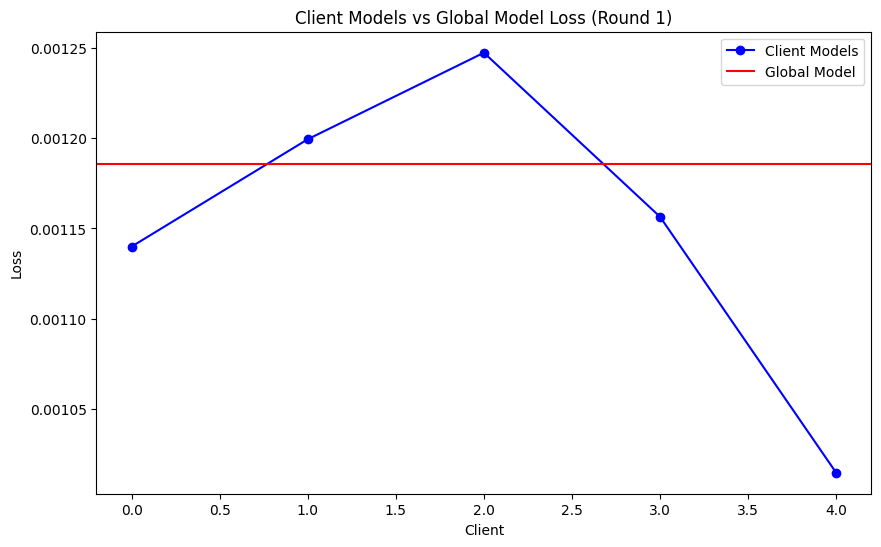

546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


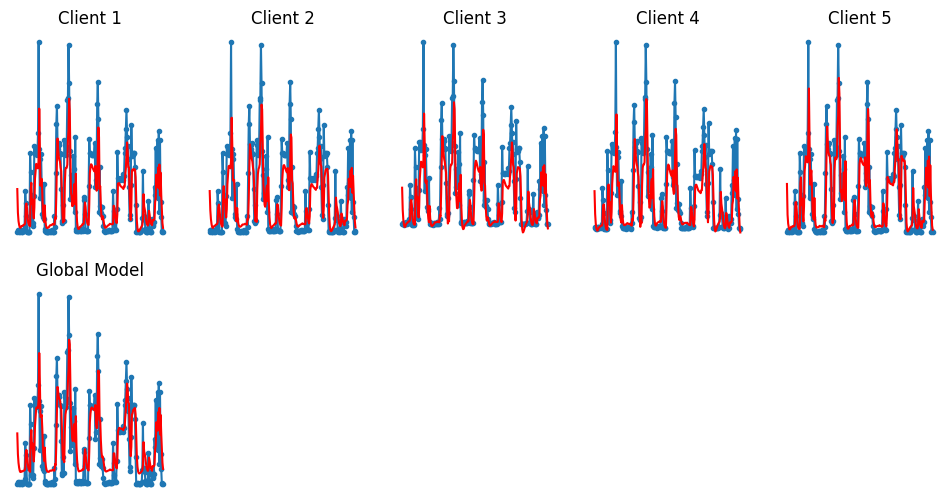

Round 2/5
Training client model 1...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 3.3090e-04 - loss: 0.0018
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 2.4004e-04 - loss: 4.1616e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 4.4098e-04 - loss: 4.9937e-04
Training client model 2...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 1.6579e-04 - loss: 8.2831e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 3.7628e-04 - loss: 0.0012
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 1.9141e-04 - loss: 4.4075e-04
Training client model 3...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 5.9725e-04 - loss: 0.0023
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1661 - loss: 7.3032e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 4.7392e-05 - loss: 5.0928e-04
Training client model 4...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 2.2243e-04 - los

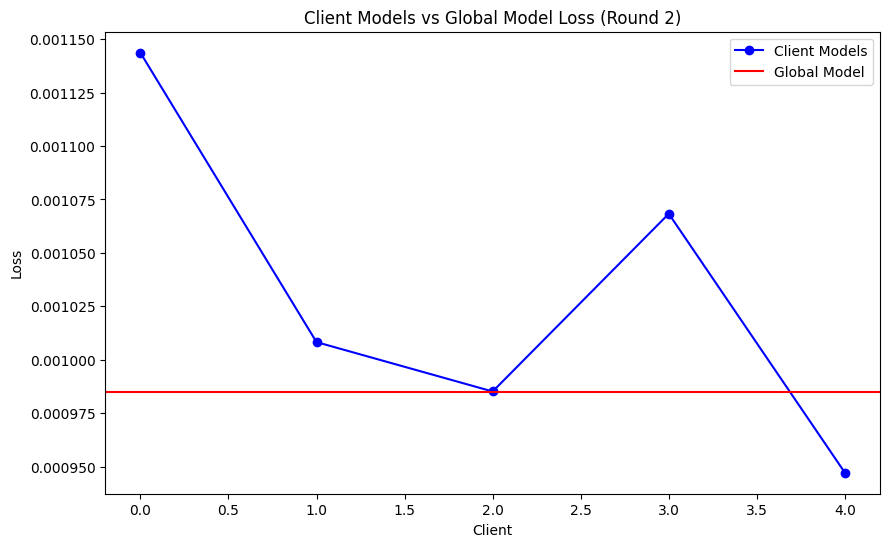

546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


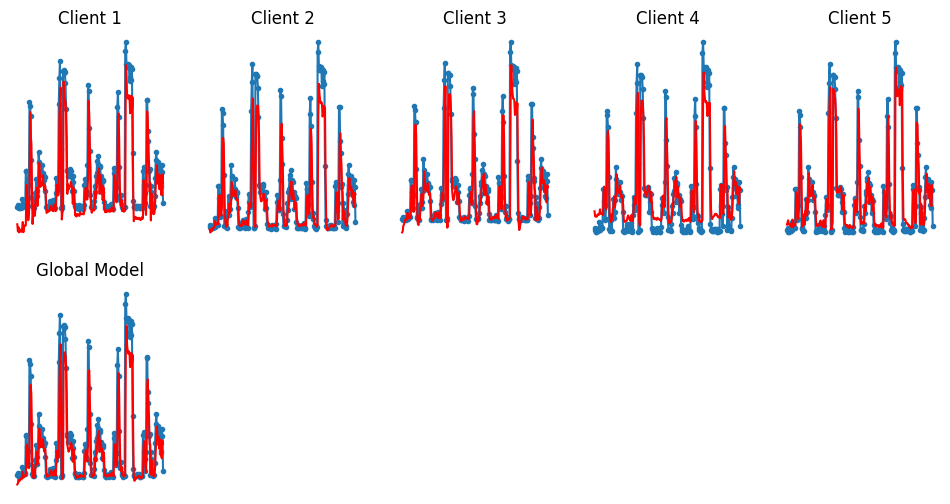

Round 3/5
Training client model 1...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 2.5415e-04 - loss: 0.0018
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 7.4781e-05 - loss: 3.9343e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 3.2454e-04 - loss: 5.0891e-04
Training client model 2...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 1.1537e-04 - loss: 7.9002e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 9.1007e-05 - loss: 0.0012
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 5.1468e-05 - loss: 4.2543e-04
Training client model 3...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 1.5037e-04 - loss: 0.0021
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1717 - loss: 7.7729e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 7.9178e-05 - loss: 4.6471e-04
Training client model 4...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 1.8628e-05 - los

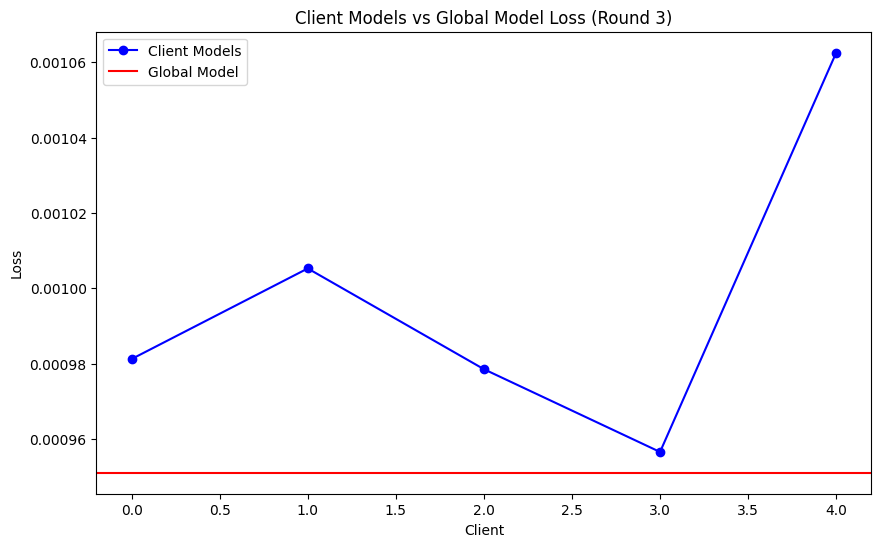

546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


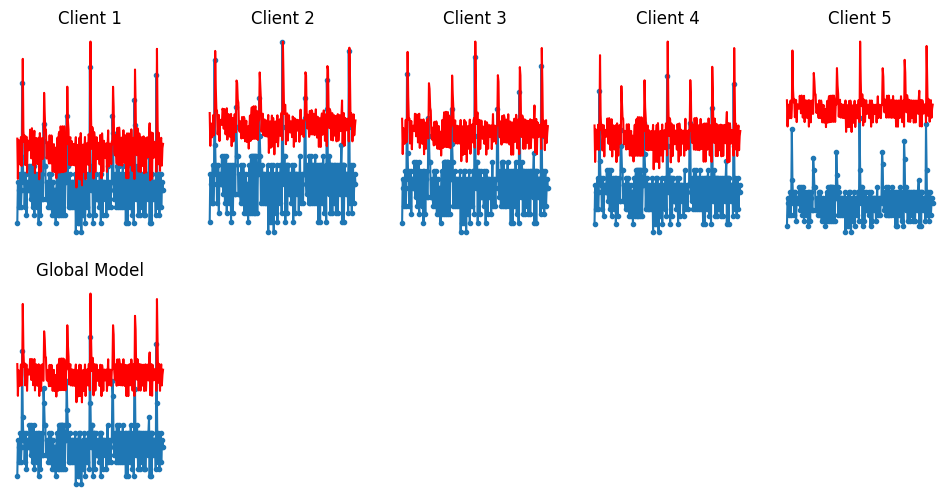

Round 4/5
Training client model 1...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 6.0180e-04 - loss: 0.0018
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 1.4540e-04 - loss: 3.6465e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 5.7961e-04 - loss: 5.0097e-04
Training client model 2...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 6.7633e-05 - loss: 7.9443e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 2.4793e-04 - loss: 0.0011
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 3.8449e-04 - loss: 4.4393e-04
Training client model 3...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 2.4813e-04 - loss: 0.0021
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1673 - loss: 7.9384e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 3.2095e-04 - loss: 4.7707e-04
Training client model 4...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 1.1114e-04 - los

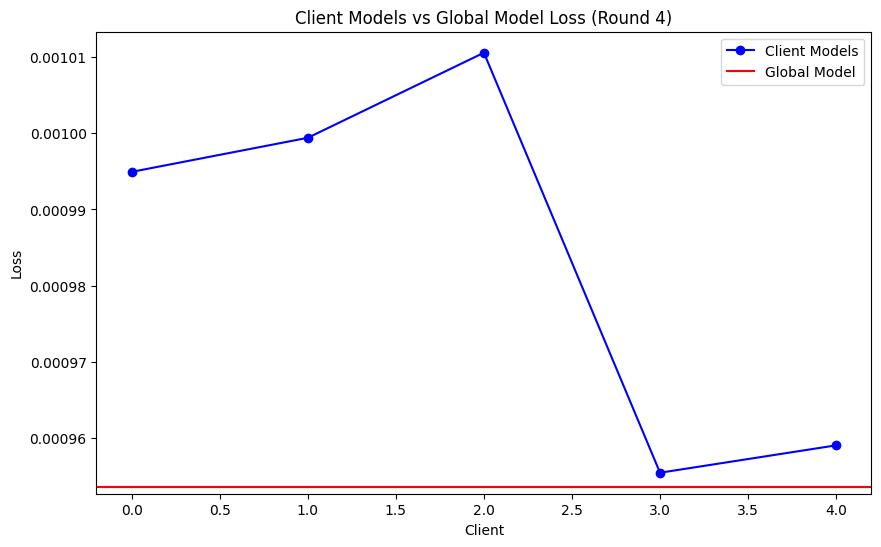

546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


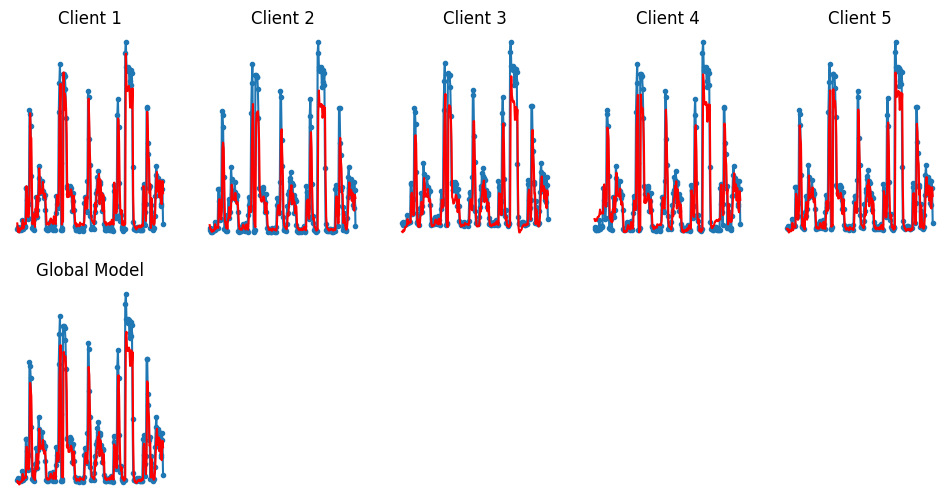

Round 5/5
Training client model 1...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 9.9778e-04 - loss: 0.0017
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 1.0166e-04 - loss: 4.0837e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 5.0679e-04 - loss: 5.2073e-04
Training client model 2...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 2.9471e-05 - loss: 7.3261e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 1.4404e-05 - loss: 0.0011
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 2.1167e-05 - loss: 4.3628e-04
Training client model 3...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 3.2477e-04 - loss: 0.0020
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1709 - loss: 7.9635e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 1.3785e-04 - loss: 4.9812e-04
Training client model 4...
(3, 17472, 48, 1)
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 2.3488e-04 - los

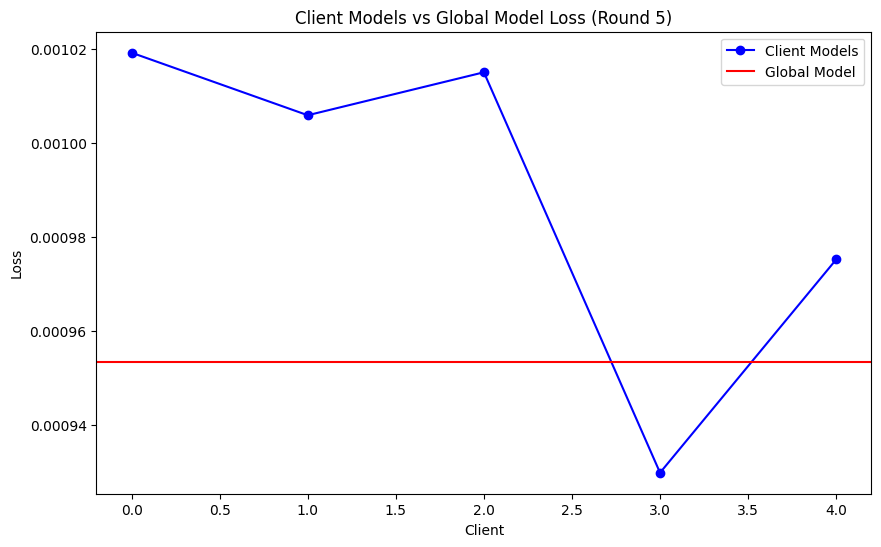

546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


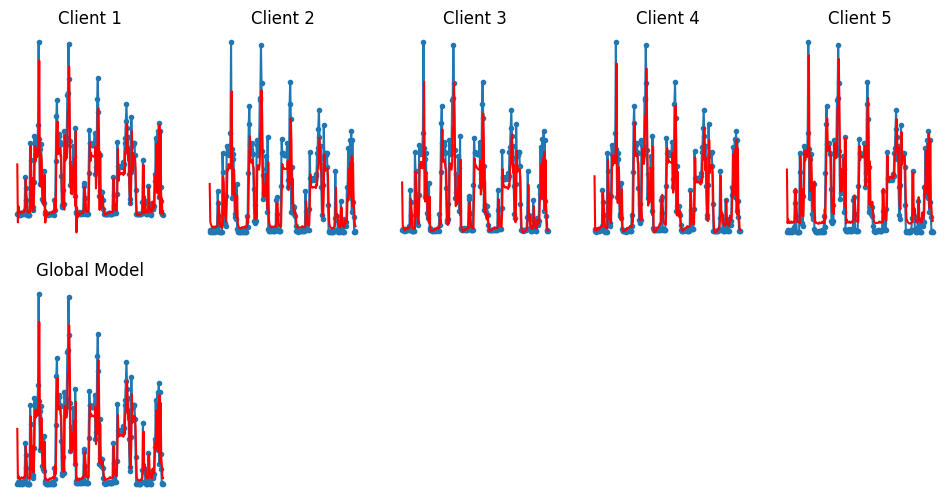

In [44]:
print(x_test.shape, y_test.shape)

# Running federated learning
num_rounds = 5
global_model, global_model_loss = federated_learning(num_rounds, num_clients, client_data)

test loss :  0.0018214537994936109
test loss :  0.000765274977311492
test loss :  0.00027319914079271257
Total loss :  0.0028599279175978154 Length :  3
Final global model test loss: 0.000953


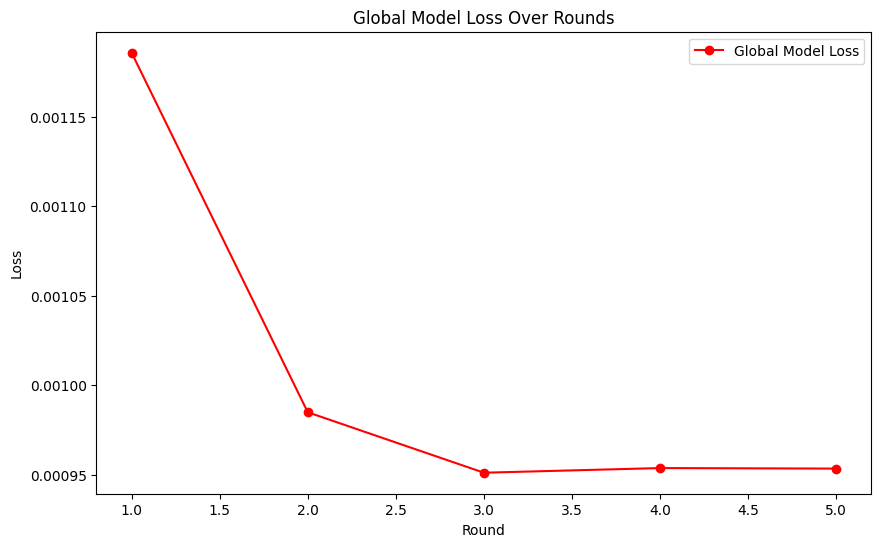

In [48]:
# Evaluate global model
# test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=0)
test_loss, test_acc = evaluate_global(global_model, x_test, y_test)
print(f'Final global model test loss: {test_loss:f}')

# Show loss of global model for each stage
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_rounds + 1), global_model_loss, 'r-o', label='Global Model Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Global Model Loss Over Rounds')
plt.legend()
plt.show()

546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


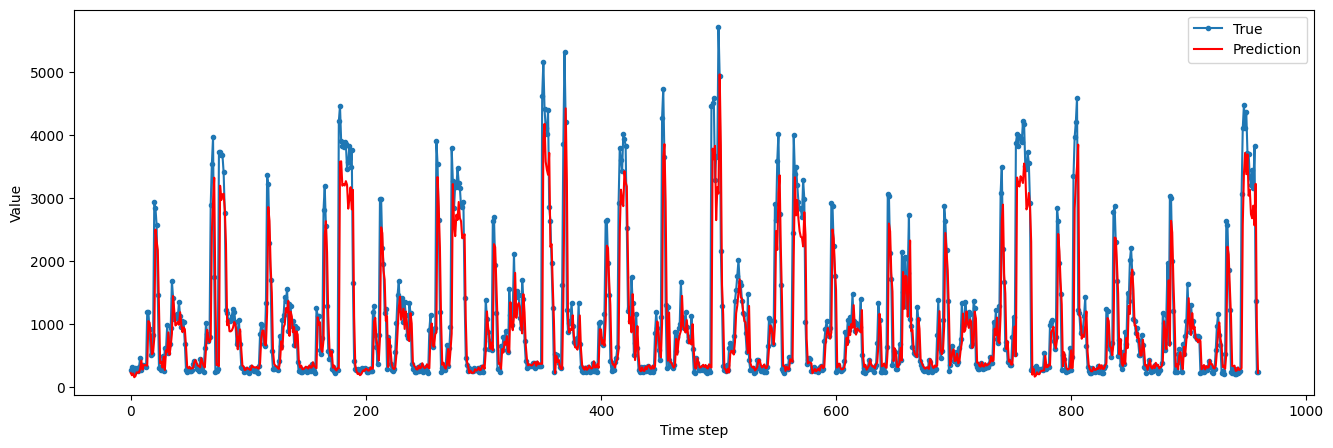

In [47]:
y_pred = global_model.predict(x_test[0])
plt.figure(figsize=(16, 5))
plt.plot(y_test[0][:48*20]*normalize, marker='.', label='True')
plt.plot(y_pred[:48*20]*normalize, 'r', label='Prediction')
plt.ylabel('Value')
plt.xlabel('Time step')
plt.legend()
plt.show()
